<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/ResNet(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 패키지 로드

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 4.7 MB/s 
     |████████████████████████████████| 37.1 MB 87 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. 논문 분석

* ResNet의 가장 중요한 특징은 residual block이다. 
    * 신경망이 깊어질 수록 어느 순간부터 degradation 문제가 발생한다. 이는 모델의 정확도가 좋아지다가 어느순간부터 정체되고, 더 나아가서 성능이 나빠지는 현상이다. 
    * 이는 overfeating과 다른 것이 train 에러와, val 에러가 모두 커지기 때문이다. 오버피팅문제였다면 train 에러는 개선되어야한다.
    * 논문에서 원인을 명백하게 밝히지 않았으며, 실험결과 18레이어보다 34레이어의 에러가 큰 것은 gradient vanishing 문제가 아니라고 밝히고 있다. 또한 이 문제의 자세한 것은 추후의 연구에 맡긴다고 적혀있다.
    * 중요한 것은 degradation 이 residual block 이라는 아이디어로 어느 정도 해결 될 수 있다는 것.
    * residual mapping이 아이디어는 identity mapping에서 출발. 극단적인 가정으로 '층이 깊어지지만 그 층들이 identity mapping이라면 최소한 나빠지지는 않을 것이다. ' 라는 생각에서 출발. 근데, 실제로 학습을 identity mapping 처럼하는 과정은 너무나 unable to do so in feasible time이다. 따라어 이 논문에서는 resnet framework를 제안함. 이는 레이어가 underlying mapping을 학습하는 것이 아닌 residual mapping에 맞춰 학습하게 함.

            *개인적으로 이 부분에서 underlying mapping 즉, identity 맵핑을 직접학습하는게 어려우니까 잔차를 0으로 학습하게 만든다는 생각으로 블럭을 만들었다고 생각함.
    * 극단적으로 함수의 최적이 identity 라고 가정하면, residual을 zero로 만드는 것이 nonlinear 층들을 identity로 만드는 것보다 훨씬 쉬울 것임.
    * 따라서 F(x) + x 에서 F(x)를 학습시키기위해 x라는 shortcut connection을 추가함.

            자세한 내용은 너무 길어질 것 같으니, 핵심내용(res block)만 설명 하고, 구현으로 넘어가자


* ResNet 구현 관련 이슈

    * 구조는 아래와 같다.
    * **내가 구현할 50층 이상의 deep한 놈은 단순히 shortcut만 추가하는 것이 아니라, 1x1 conv를 이용해 채널을 압축하고 3x3 이후 다시 1x1로 사이즈를 맞춰주는 bottleneck 구조가 필요하다.** 이는 정보를 압축하는 대신 계산량을 줄여준다. 이 부분 구현이 조금 까다로울 듯.
    * resnet50은 블럭 단위로 3/4/6/3의 conv세트를 구성하는게 
    * feature map의 크기를 자를 때 이전의 모델과 달리 pooling 말고 stride 2를 해서 잘라버림. resnet 기준으로 이 후 pooling 보다 stride가 많이 쓰임
    * 피쳐맵 크기는 절반 depth는 두배로

* 그 외의 디테일
    * decay = 0.0001, momentum 0.9
    * learing rate 초기값 = 0.1 이후 1/10씩 감소
    * dropout 하지 않음
    * crop은 모서리에서 10번 , 중앙부 2번 총 10번 진행
    * he initialization
    * 이번 구현은 블락 구현이 핵심이므로 세세한 부분, 가령 augmentation 등등은 논문 그대로를 따라가지 않겠음.



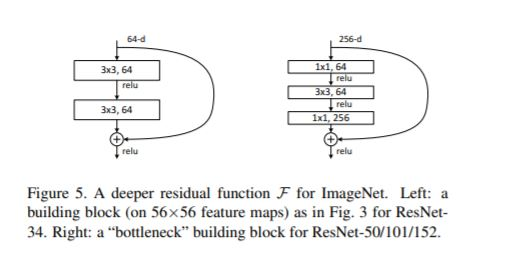

---
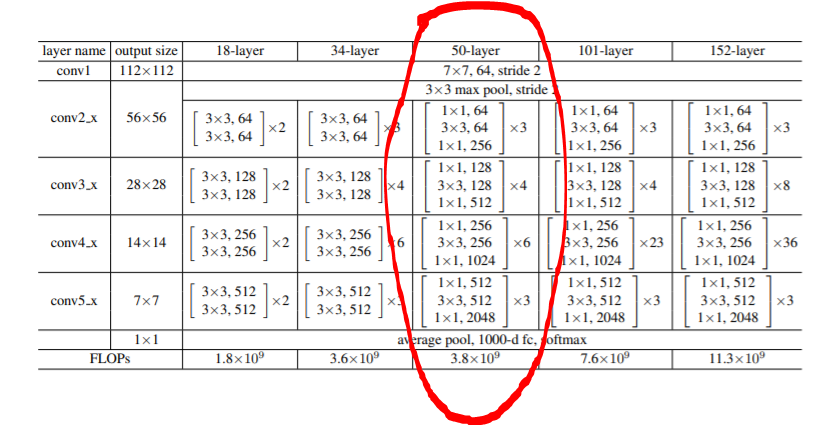

---
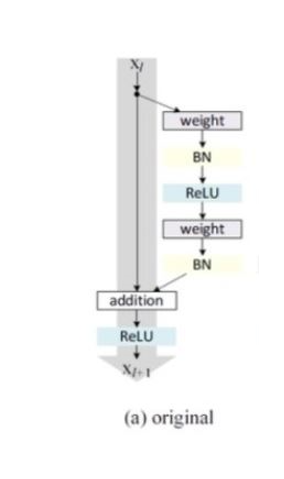



# 3. 구현

## 블럭 구현

resnet50을 구현하기 위해 bottleneck 구조를 구현해야함.

또한 사이즈를 절반으로 줄이는 옵션인 down도 필요


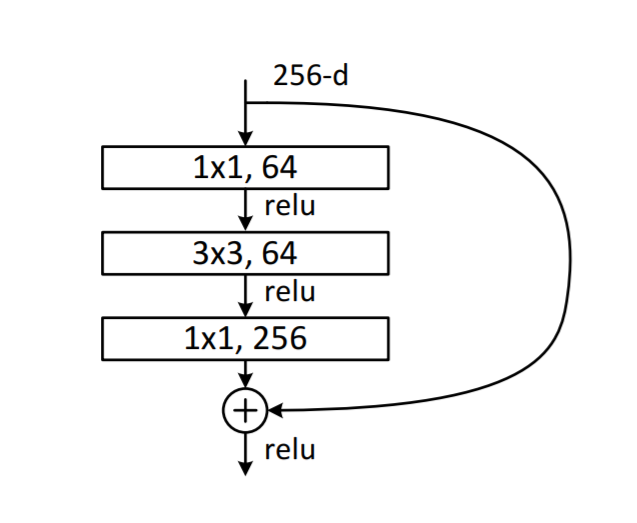

* 여기서 헷갈릴 수 있는 내용. 
    * 아래 그림에서 256채널이 들어와서 1/4로 차원 축소해서 계산량을 줄여서 3x3 conv을 한다음 다시 256채널로 늘린다. 첫번째 블락만 독특하게 64개를 받아서 256개로 바꿈. 이 때, 헷갈리는게 첫 블럭의 ishortcut부분 또한 사이즈를 조절해서 256개로 늘려서 더해줘야 차원이 맞음.
    * 또한 더해지는 값은 채널을 concate하는게 아니라 add하는 것이므로 resblock의 채널은 유지된다.

In [ ]:
class BasicBlock(nn.Module):
    """
    channels : [입력, 중간, 출력] 필터의 수를 원소 3개의 리스트로 받아온다.
    down : 필터사이즈를 절반으로 줄이고, 채널을 두배로 늘릴 것인지
    """
    def __init__(self, channels, down = False, first = False):
        super(BasicBlock, self).__init__()
        layers = []
        down_shortcut = []
        self.down = down

        if first:
            down_shortcut.append(nn.Conv2d(channels[0], channels[2], kernel_size=1, bias = False))
            layers.append(nn.Conv2d(channels[0], channels[1], kernel_size=1, bias = False))
        else :
            down_shortcut.append(nn.Conv2d(channels[0], channels[2], kernel_size=1,stride = 2, bias = False))
            if down:
                layers.append(nn.Conv2d(channels[0], channels[1], kernel_size=1, stride=2, bias = False))
            else :
                layers.append(nn.Conv2d(channels[0], channels[1], kernel_size=1, bias = False))

        down_shortcut.append(nn.BatchNorm2d(channels[2]))


        layers.extend([
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),
            
            nn.Conv2d(channels[1], channels[1], kernel_size=3, stride=1, padding='same', bias = False),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),

            nn.Conv2d(channels[1], channels[2], kernel_size=1, bias = False),
            nn.BatchNorm2d(channels[2]),
         ])
        

        

        self.block_layer = nn.Sequential(*layers)
        self.down_shortcut_block =  nn.Sequential(*down_shortcut)

    def forward(self, input_tensor):        
        if self.down :
            identity = self.down_shortcut_block(input_tensor)
            x = self.block_layer(input_tensor)
            x += identity
            output = nn.ReLU()(x)
        else :
            identity = input_tensor
            x = self.block_layer(input_tensor)
            x += identity
            output = nn.ReLU()(x)

        return output

       



# model = BasicBlock([64,64,256],True,True).to(device)
# summary(model, (64, 224,224))
# print(model)

model = BasicBlock([256,64,256]).to(device)
summary(model, (256, 224,224))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]          16,384
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7        [-1, 256, 224, 224]          16,384
       BatchNorm2d-8        [-1, 256, 224, 224]             512
Total params: 70,400
Trainable params: 70,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 49.00
Forward/backward pass size (MB): 343.00
Params size (MB): 0.27
Estimated Total Size (MB): 392.27
----------------------------------------------------------------
BasicBlock(
  (block_layer): Sequential

블럭의 first는 입구에서 크기를 안줄임.
그렇지만 차원은 256으로 반환함
first는 딱 1번만 나옴

first의 down은 shortcut에서 stride가 없음
down은 있음
중간 반복부분은 그냥 더함


다운뒤에 반복수-1 만큼 다운과 다른놈들이등장


## 블럭셋 구현
여러 개가 동시에 붙어있게

In [ ]:
class ResBlockSet(nn.Module):
    """
    기본블럭을 받아서 resnet블럭을 반복해서 쌓음.
    channels : [입력, 중간, 출력] 채널의 수를 원소 3개의 리스트로 받아온다.

    *주의: 중간에 들어가는 필터의 수가 아님! 처음 인자는 입력 인풋. 토치는 인풋 채널을 받음.
    *주의: 블럭셋 단위로 첫블럭은 이전 블럭의 출력이 아웃풋이고, 다음 블럭들은
    이번 블럭들의 아웃풋이 출력이다. 그래서 아래에 구현해놓았음(주석부분)
    *first는 block의 처음이 아니라 blockset 자체의 처음을 의미함(처음 한번만 수행)

    repeat : 반복수
    first : 처음 층은 사이즈를 줄이지 않으면서 받아온다.
    """
    def __init__(self, channels, repeat, first = False):
        super(ResBlockSet, self).__init__()        
        self.repeat = repeat
        layers = []

        if first:
            layers.append(BasicBlock([channels[0],channels[1],channels[2]],True,True))
        else:
            layers.append(BasicBlock([channels[0],channels[1],channels[2]],True,False))

        for i in range(repeat-1) :
            # 이 부분 중간 레스블럭은 커진놈을 받아서 줄였다가 다시 키움. 그래서 212로.
            # channels1은 입력채널의 수
            layers.append(BasicBlock([channels[2],channels[1],channels[2]]))

        self.blockset = nn.Sequential(*layers)




    def forward(self, input_tensor):
        return self.blockset(input_tensor)

model = ResBlockSet([64,64,256],3,True).to(device)
summary(model, (64, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 224, 224]          16,384
       BatchNorm2d-2        [-1, 256, 224, 224]             512
            Conv2d-3         [-1, 64, 224, 224]           4,096
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
            Conv2d-6         [-1, 64, 224, 224]          36,864
       BatchNorm2d-7         [-1, 64, 224, 224]             128
              ReLU-8         [-1, 64, 224, 224]               0
            Conv2d-9        [-1, 256, 224, 224]          16,384
      BatchNorm2d-10        [-1, 256, 224, 224]             512
       BasicBlock-11        [-1, 256, 224, 224]               0
           Conv2d-12         [-1, 64, 224, 224]          16,384
      BatchNorm2d-13         [-1, 64, 224, 224]             128
             ReLU-14         [-1, 64, 2

## resnet50 구현

In [ ]:
class ResNet50(nn.Module):
    ''' resnet model을 만들어서 반환해준다'''
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()        

        # 원본 conv1이 사이즈를 맞추기 위해 zeorpadding을 3으로 한번 1로 한번 함.
        # 나는 96짜리 넣을 거라 필요 없지만, 원본과 동일하게 가기로.
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride = 2,padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2,padding=1)                               
        )

        self.conv2 = ResBlockSet([64,64,256],3,True)
        self.conv3 = ResBlockSet([256,128,512],4)
        self.conv4 = ResBlockSet([512,256,1024],6)
        self.conv5 = ResBlockSet([1024,512,2048],3)
        self.gap =  nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classifier =  nn.Linear(2048, num_classes)



        self._initialize_weights()



    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)
        x = self.flatten(x) 
        # x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x


In [ ]:
# 모델 확인
model = ResNet50().to(device)
summary(model, (3, 96,96))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 256, 24, 24]          16,384
       BatchNorm2d-6          [-1, 256, 24, 24]             512
            Conv2d-7           [-1, 64, 24, 24]           4,096
       BatchNorm2d-8           [-1, 64, 24, 24]             128
              ReLU-9           [-1, 64, 24, 24]               0
           Conv2d-10           [-1, 64, 24, 24]          36,864
      BatchNorm2d-11           [-1, 64, 24, 24]             128
             ReLU-12           [-1, 64, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 4. 데이터 전처리

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

(3, 96, 96)
torch.Size([3, 96, 96])


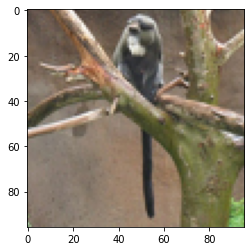

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


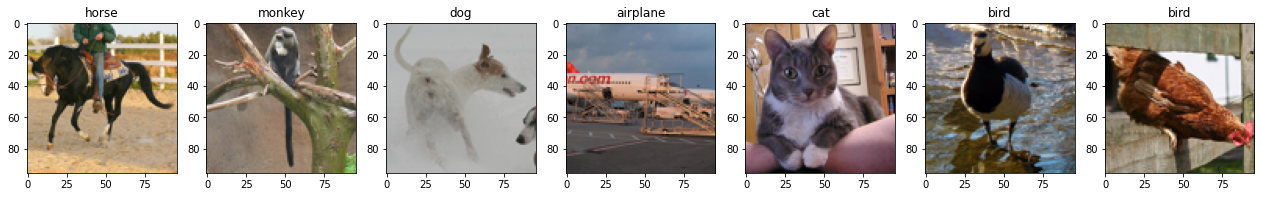

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




# 5. 학습 및 평가

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = ResNet50(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


[1] Train Loss: 2.0738, Accuracy: 21.59%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.40it/s]


[1] Validation Loss: 1.8707, Accuracy: 25.98%
Validation loss decreased (inf --> 1.870704).



Epoch: 2. Train.: 100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


[2] Train Loss: 1.8280, Accuracy: 29.29%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


[2] Validation Loss: 1.8365, Accuracy: 30.92%
Validation loss decreased (1.870704 --> 1.836504).



Epoch: 3. Train.: 100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


[3] Train Loss: 1.7798, Accuracy: 31.90%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]


[3] Validation Loss: 1.7004, Accuracy: 33.34%
Validation loss decreased (1.836504 --> 1.700441).



Epoch: 4. Train.: 100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


[4] Train Loss: 1.7250, Accuracy: 33.89%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


[4] Validation Loss: 1.6499, Accuracy: 35.76%
Validation loss decreased (1.700441 --> 1.649851).



Epoch: 5. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[5] Train Loss: 1.6853, Accuracy: 36.52%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


[5] Validation Loss: 1.6084, Accuracy: 38.06%
Validation loss decreased (1.649851 --> 1.608357).



Epoch: 6. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[6] Train Loss: 1.6353, Accuracy: 38.01%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


[6] Validation Loss: 1.7093, Accuracy: 35.98%
EarlyStopping counter: 1 out of 15



Epoch: 7. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[7] Train Loss: 1.6131, Accuracy: 38.52%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.11it/s]


[7] Validation Loss: 1.6103, Accuracy: 39.50%
EarlyStopping counter: 2 out of 15



Epoch: 8. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[8] Train Loss: 1.5510, Accuracy: 41.66%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[8] Validation Loss: 1.5655, Accuracy: 42.08%
Validation loss decreased (1.608357 --> 1.565492).



Epoch: 9. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[9] Train Loss: 1.5295, Accuracy: 42.91%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[9] Validation Loss: 1.4148, Accuracy: 47.28%
Validation loss decreased (1.565492 --> 1.414785).



Epoch: 10. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[10] Train Loss: 1.4974, Accuracy: 44.56%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[10] Validation Loss: 1.4033, Accuracy: 47.38%
Validation loss decreased (1.414785 --> 1.403335).



Epoch: 11. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[11] Train Loss: 1.4657, Accuracy: 45.40%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[11] Validation Loss: 1.3983, Accuracy: 47.26%
Validation loss decreased (1.403335 --> 1.398325).



Epoch: 12. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[12] Train Loss: 1.4314, Accuracy: 47.80%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[12] Validation Loss: 1.3503, Accuracy: 50.66%
Validation loss decreased (1.398325 --> 1.350320).



Epoch: 13. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[13] Train Loss: 1.4073, Accuracy: 47.73%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[13] Validation Loss: 1.4654, Accuracy: 48.02%
EarlyStopping counter: 1 out of 15



Epoch: 14. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[14] Train Loss: 1.3848, Accuracy: 48.90%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[14] Validation Loss: 1.3252, Accuracy: 50.80%
Validation loss decreased (1.350320 --> 1.325190).



Epoch: 15. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[15] Train Loss: 1.3478, Accuracy: 50.35%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[15] Validation Loss: 1.2834, Accuracy: 53.30%
Validation loss decreased (1.325190 --> 1.283400).



Epoch: 16. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[16] Train Loss: 1.3334, Accuracy: 50.96%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


[16] Validation Loss: 1.3807, Accuracy: 50.86%
EarlyStopping counter: 1 out of 15



Epoch: 17. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[17] Train Loss: 1.3147, Accuracy: 51.09%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[17] Validation Loss: 1.2425, Accuracy: 54.08%
Validation loss decreased (1.283400 --> 1.242517).



Epoch: 18. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[18] Train Loss: 1.2832, Accuracy: 52.58%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[18] Validation Loss: 1.1876, Accuracy: 56.14%
Validation loss decreased (1.242517 --> 1.187604).



Epoch: 19. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[19] Train Loss: 1.2498, Accuracy: 54.58%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[19] Validation Loss: 1.1690, Accuracy: 58.00%
Validation loss decreased (1.187604 --> 1.169011).



Epoch: 20. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[20] Train Loss: 1.2481, Accuracy: 54.01%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[20] Validation Loss: 1.2336, Accuracy: 54.66%
EarlyStopping counter: 1 out of 15



Epoch: 21. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[21] Train Loss: 1.2301, Accuracy: 55.79%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[21] Validation Loss: 1.2525, Accuracy: 53.94%
EarlyStopping counter: 2 out of 15



Epoch: 22. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[22] Train Loss: 1.1956, Accuracy: 56.79%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[22] Validation Loss: 1.1218, Accuracy: 58.70%
Validation loss decreased (1.169011 --> 1.121817).



Epoch: 23. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[23] Train Loss: 1.1733, Accuracy: 56.62%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[23] Validation Loss: 1.0644, Accuracy: 61.06%
Validation loss decreased (1.121817 --> 1.064410).



Epoch: 24. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[24] Train Loss: 1.1574, Accuracy: 57.95%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[24] Validation Loss: 1.1368, Accuracy: 58.54%
EarlyStopping counter: 1 out of 15



Epoch: 25. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[25] Train Loss: 1.1355, Accuracy: 58.95%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


[25] Validation Loss: 1.1311, Accuracy: 59.46%
EarlyStopping counter: 2 out of 15



Epoch: 26. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[26] Train Loss: 1.1139, Accuracy: 59.67%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[26] Validation Loss: 1.1902, Accuracy: 58.46%
EarlyStopping counter: 3 out of 15



Epoch: 27. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[27] Train Loss: 1.0925, Accuracy: 60.42%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[27] Validation Loss: 1.0227, Accuracy: 63.70%
Validation loss decreased (1.064410 --> 1.022688).



Epoch: 28. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[28] Train Loss: 1.0970, Accuracy: 59.61%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[28] Validation Loss: 1.1728, Accuracy: 58.66%
EarlyStopping counter: 1 out of 15



Epoch: 29. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[29] Train Loss: 1.0625, Accuracy: 61.51%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[29] Validation Loss: 1.0464, Accuracy: 62.18%
EarlyStopping counter: 2 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[30] Train Loss: 1.0437, Accuracy: 62.75%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[30] Validation Loss: 1.0327, Accuracy: 63.36%
EarlyStopping counter: 3 out of 15



Epoch: 31. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[31] Train Loss: 1.0042, Accuracy: 64.09%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[31] Validation Loss: 1.1216, Accuracy: 60.88%
EarlyStopping counter: 4 out of 15



Epoch: 32. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[32] Train Loss: 1.0166, Accuracy: 63.86%


Epoch: 32. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[32] Validation Loss: 1.0138, Accuracy: 64.26%
Validation loss decreased (1.022688 --> 1.013837).



Epoch: 33. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[33] Train Loss: 0.9917, Accuracy: 64.46%


Epoch: 33. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[33] Validation Loss: 1.0375, Accuracy: 63.96%
EarlyStopping counter: 1 out of 15



Epoch: 34. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[34] Train Loss: 0.9702, Accuracy: 65.45%


Epoch: 34. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


[34] Validation Loss: 0.9927, Accuracy: 64.24%
Validation loss decreased (1.013837 --> 0.992699).



Epoch: 35. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[35] Train Loss: 0.9664, Accuracy: 65.15%


Epoch: 35. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[35] Validation Loss: 1.0266, Accuracy: 63.46%
EarlyStopping counter: 1 out of 15



Epoch: 36. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[36] Train Loss: 0.9534, Accuracy: 65.90%


Epoch: 36. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[36] Validation Loss: 0.9555, Accuracy: 66.72%
Validation loss decreased (0.992699 --> 0.955526).



Epoch: 37. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[37] Train Loss: 0.9291, Accuracy: 65.97%


Epoch: 37. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[37] Validation Loss: 0.9829, Accuracy: 65.82%
EarlyStopping counter: 1 out of 15



Epoch: 38. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[38] Train Loss: 0.9101, Accuracy: 67.14%


Epoch: 38. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[38] Validation Loss: 1.2571, Accuracy: 58.00%
EarlyStopping counter: 2 out of 15



Epoch: 39. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[39] Train Loss: 0.8944, Accuracy: 67.89%


Epoch: 39. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[39] Validation Loss: 0.9543, Accuracy: 66.78%
Validation loss decreased (0.955526 --> 0.954318).



Epoch: 40. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[40] Train Loss: 0.8725, Accuracy: 69.06%


Epoch: 40. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[40] Validation Loss: 0.9647, Accuracy: 66.70%
EarlyStopping counter: 1 out of 15



Epoch: 41. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[41] Train Loss: 0.8563, Accuracy: 69.81%


Epoch: 41. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[41] Validation Loss: 0.9632, Accuracy: 67.06%
EarlyStopping counter: 2 out of 15



Epoch: 42. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[42] Train Loss: 0.8661, Accuracy: 68.72%


Epoch: 42. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[42] Validation Loss: 0.9864, Accuracy: 65.44%
EarlyStopping counter: 3 out of 15



Epoch: 43. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[43] Train Loss: 0.8512, Accuracy: 69.65%


Epoch: 43. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[43] Validation Loss: 0.9493, Accuracy: 66.42%
Validation loss decreased (0.954318 --> 0.949253).



Epoch: 44. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[44] Train Loss: 0.8317, Accuracy: 70.20%


Epoch: 44. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[44] Validation Loss: 0.9480, Accuracy: 67.30%
Validation loss decreased (0.949253 --> 0.948008).



Epoch: 45. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[45] Train Loss: 0.8198, Accuracy: 70.45%


Epoch: 45. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[45] Validation Loss: 0.9271, Accuracy: 68.58%
Validation loss decreased (0.948008 --> 0.927147).



Epoch: 46. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[46] Train Loss: 0.8094, Accuracy: 70.61%


Epoch: 46. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[46] Validation Loss: 0.9407, Accuracy: 67.90%
EarlyStopping counter: 1 out of 15



Epoch: 47. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[47] Train Loss: 0.8020, Accuracy: 71.08%


Epoch: 47. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[47] Validation Loss: 0.9430, Accuracy: 67.40%
EarlyStopping counter: 2 out of 15



Epoch: 48. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[48] Train Loss: 0.7735, Accuracy: 72.36%


Epoch: 48. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]


[48] Validation Loss: 0.9728, Accuracy: 67.78%
EarlyStopping counter: 3 out of 15



Epoch: 49. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[49] Train Loss: 0.7669, Accuracy: 72.54%


Epoch: 49. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[49] Validation Loss: 0.9815, Accuracy: 67.08%
EarlyStopping counter: 4 out of 15



Epoch: 50. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[50] Train Loss: 0.7862, Accuracy: 71.53%


Epoch: 50. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[50] Validation Loss: 0.9771, Accuracy: 66.92%
EarlyStopping counter: 5 out of 15



Epoch: 51. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[51] Train Loss: 0.7487, Accuracy: 73.61%


Epoch: 51. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[51] Validation Loss: 0.9766, Accuracy: 66.60%
EarlyStopping counter: 6 out of 15



Epoch: 52. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[52] Train Loss: 0.7499, Accuracy: 73.25%


Epoch: 52. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[52] Validation Loss: 0.9479, Accuracy: 68.36%
EarlyStopping counter: 7 out of 15



Epoch: 53. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[53] Train Loss: 0.7120, Accuracy: 74.54%


Epoch: 53. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[53] Validation Loss: 1.5084, Accuracy: 59.34%
EarlyStopping counter: 8 out of 15



Epoch: 54. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[54] Train Loss: 0.7068, Accuracy: 75.00%


Epoch: 54. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[54] Validation Loss: 0.9356, Accuracy: 68.84%
EarlyStopping counter: 9 out of 15



Epoch: 55. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[55] Train Loss: 0.7050, Accuracy: 74.76%


Epoch: 55. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[55] Validation Loss: 0.9397, Accuracy: 68.16%
EarlyStopping counter: 10 out of 15



Epoch: 56. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[56] Train Loss: 0.6676, Accuracy: 76.47%


Epoch: 56. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[56] Validation Loss: 1.2512, Accuracy: 65.34%
Epoch    56: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 11 out of 15



Epoch: 57. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[57] Train Loss: 0.5869, Accuracy: 79.28%


Epoch: 57. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[57] Validation Loss: 0.7675, Accuracy: 73.94%
Validation loss decreased (0.927147 --> 0.767496).



Epoch: 58. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[58] Train Loss: 0.5284, Accuracy: 82.10%


Epoch: 58. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.10it/s]


[58] Validation Loss: 0.7465, Accuracy: 74.68%
Validation loss decreased (0.767496 --> 0.746450).



Epoch: 59. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[59] Train Loss: 0.5246, Accuracy: 81.94%


Epoch: 59. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.07it/s]


[59] Validation Loss: 0.7486, Accuracy: 75.12%
EarlyStopping counter: 1 out of 15



Epoch: 60. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[60] Train Loss: 0.5337, Accuracy: 81.41%


Epoch: 60. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[60] Validation Loss: 0.7424, Accuracy: 74.88%
Validation loss decreased (0.746450 --> 0.742406).



Epoch: 61. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[61] Train Loss: 0.5019, Accuracy: 82.51%


Epoch: 61. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[61] Validation Loss: 0.7522, Accuracy: 74.88%
EarlyStopping counter: 1 out of 15



Epoch: 62. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[62] Train Loss: 0.4991, Accuracy: 82.65%


Epoch: 62. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[62] Validation Loss: 0.7412, Accuracy: 75.40%
Validation loss decreased (0.742406 --> 0.741185).



Epoch: 63. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[63] Train Loss: 0.4874, Accuracy: 83.34%


Epoch: 63. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


[63] Validation Loss: 0.7562, Accuracy: 74.78%
EarlyStopping counter: 1 out of 15



Epoch: 64. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[64] Train Loss: 0.4929, Accuracy: 83.06%


Epoch: 64. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[64] Validation Loss: 0.7461, Accuracy: 75.58%
EarlyStopping counter: 2 out of 15



Epoch: 65. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[65] Train Loss: 0.4718, Accuracy: 83.83%


Epoch: 65. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[65] Validation Loss: 0.7417, Accuracy: 75.22%
EarlyStopping counter: 3 out of 15



Epoch: 66. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


[66] Train Loss: 0.4609, Accuracy: 84.51%


Epoch: 66. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[66] Validation Loss: 0.7605, Accuracy: 74.72%
EarlyStopping counter: 4 out of 15



Epoch: 67. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[67] Train Loss: 0.4728, Accuracy: 83.74%


Epoch: 67. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[67] Validation Loss: 0.7434, Accuracy: 75.04%
EarlyStopping counter: 5 out of 15



Epoch: 68. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[68] Train Loss: 0.4708, Accuracy: 84.11%


Epoch: 68. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]


[68] Validation Loss: 0.7449, Accuracy: 75.98%
EarlyStopping counter: 6 out of 15



Epoch: 69. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[69] Train Loss: 0.4619, Accuracy: 84.30%


Epoch: 69. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[69] Validation Loss: 0.7642, Accuracy: 74.46%
EarlyStopping counter: 7 out of 15



Epoch: 70. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[70] Train Loss: 0.4575, Accuracy: 84.21%


Epoch: 70. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[70] Validation Loss: 0.7561, Accuracy: 75.36%
EarlyStopping counter: 8 out of 15



Epoch: 71. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[71] Train Loss: 0.4473, Accuracy: 84.19%


Epoch: 71. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


[71] Validation Loss: 0.7626, Accuracy: 75.16%
EarlyStopping counter: 9 out of 15



Epoch: 72. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[72] Train Loss: 0.4444, Accuracy: 84.55%


Epoch: 72. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


[72] Validation Loss: 0.7595, Accuracy: 75.16%
EarlyStopping counter: 10 out of 15



Epoch: 73. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[73] Train Loss: 0.4465, Accuracy: 84.72%


Epoch: 73. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[73] Validation Loss: 0.7619, Accuracy: 75.04%
Epoch    73: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 11 out of 15



Epoch: 74. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[74] Train Loss: 0.4274, Accuracy: 85.55%


Epoch: 74. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[74] Validation Loss: 0.7529, Accuracy: 75.34%
EarlyStopping counter: 12 out of 15



Epoch: 75. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[75] Train Loss: 0.4260, Accuracy: 85.60%


Epoch: 75. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


[75] Validation Loss: 0.7513, Accuracy: 75.28%
EarlyStopping counter: 13 out of 15



Epoch: 76. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[76] Train Loss: 0.4240, Accuracy: 85.75%


Epoch: 76. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.04it/s]


[76] Validation Loss: 0.7529, Accuracy: 75.40%
EarlyStopping counter: 14 out of 15



Epoch: 77. Train.: 100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


[77] Train Loss: 0.4226, Accuracy: 85.75%


Epoch: 77. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]

[77] Validation Loss: 0.7529, Accuracy: 75.32%
EarlyStopping counter: 15 out of 15

Early stopping


## 평가

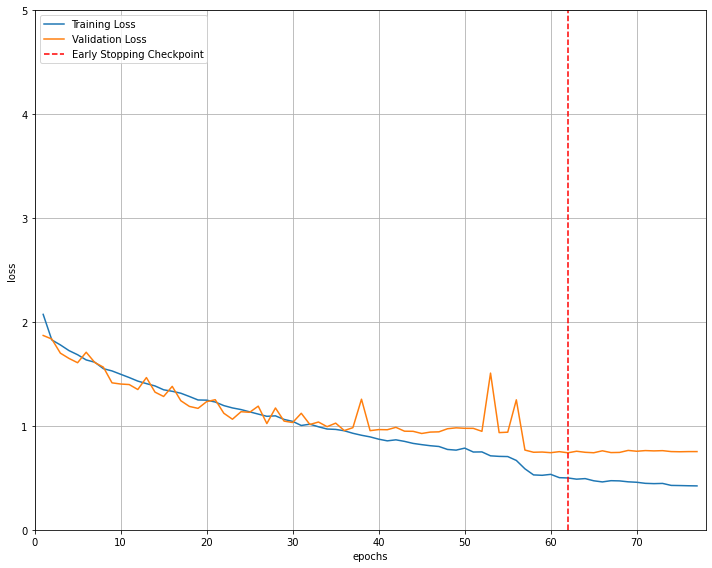

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

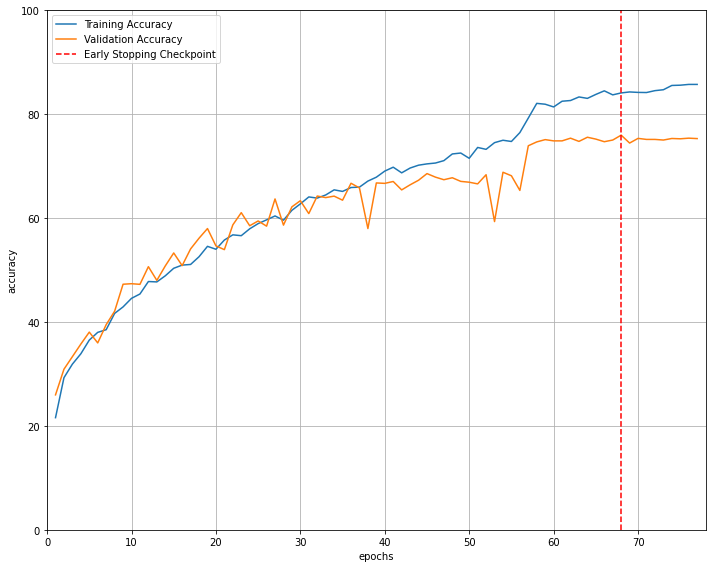

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


Test Loss: 0.7529, Accuracy: 75.32%


(0.7529374544143677, 75.32)

# 라이브러리 resnet50이랑 비교
* 만든 모델이 원하는 만큼 결과가 나오지 않는다.
torch는 모델 시각화 라이브러리가 tf에 비해 잘 작동하지 않아서 모델을 확인 할 수 있는 방법이 거의 없다. 지원해주는 라이브러리들이 커스텀모델에 대해서 코랩에서 잘 작동하지않는다.

* 따라서 pytorch 자체에서 제공하는 resnet50과 비교 해보았는데, 이 모델 자체가 원하는 만큼 성능이 나오지 않는다. class차이 epoch, 데이터 차이 등등

* train,validate,fit,커스텀데이터,albumentations 전부 비교해보았지만, 원래 라이브러리 자체도 학습이 늦고 원하는 만큼 잘 나오지 않는다.

        * 러닝레이트, 스케줄러, 데이터 증강 부분 바꾸니까 확 좋아졌음.
        

In [ ]:
from torchvision import models
import torch
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50= models.resnet50(pretrained = False).to(device)

# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')

# optimizer 정의
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.09, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# early_stopping
early_stopping = EarlyStopping(patience = 10, verbose = True)